In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install keras

In [ ]:
def get_prediction(yhat):

    return ["sunflower", "tulip", ][yhat.index(1)]

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os


2024-01-06 21:12:36.917269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 21:12:36.917304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 21:12:36.918497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 21:12:36.924880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 21:12:37.493472: W tensorflow/compiler/tf2

In [3]:
os.chdir('/media/lyonbach/work/Repositories/Sandbox/rim-identifier')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" Uncomment if you want to use CPU only

In [4]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

2024-01-06 21:12:38.083069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 21:12:38.122161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 21:12:38.122378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Here we could clean the dataset or do some other adjustments if necessary.

In [15]:
# Load data
data = tf.keras.utils.image_dataset_from_directory("dataset").map(lambda x, y: (x/255.0 , y))
# Hot encode labels for four classes
data = data.map(lambda x, y: (x, tf.one_hot(y, 2)))
iterator = data.as_numpy_iterator()

Found 1717 files belonging to 2 classes.


In [16]:
batch = iterator.next()


[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]


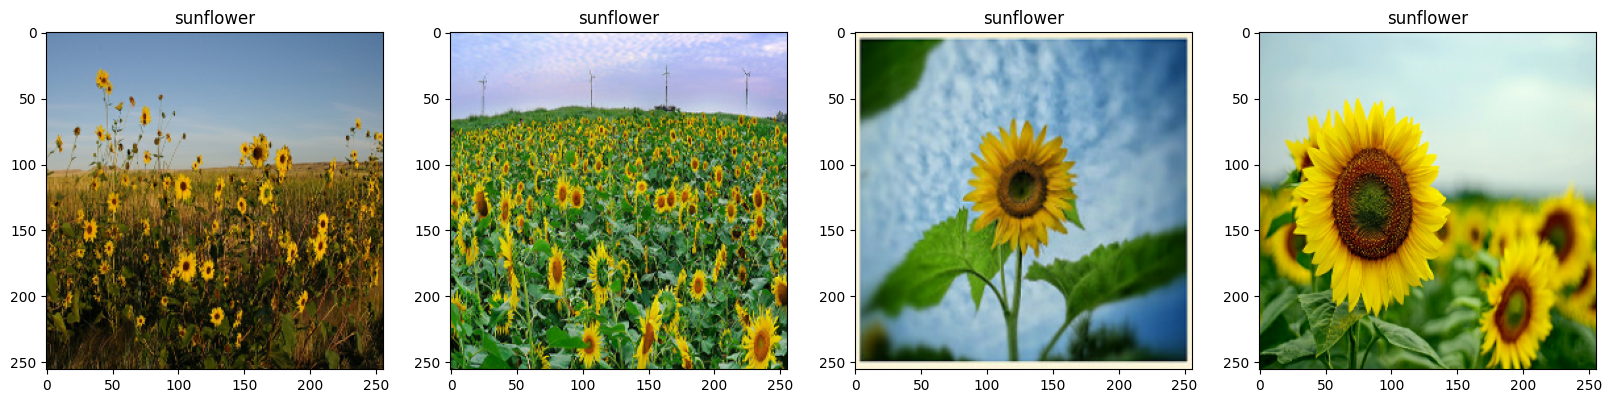

In [32]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    axs[idx].imshow(img)
    axs[idx].set_title(["sunflower", "tulip", ][list(batch[1][idx]).index(1)])
    print(batch[1][idx])


2. Split the data

In [18]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1) + 1
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size + val_size).take(test_size)

3. Build The Deep Learning Model

In [19]:
assert train_size + val_size + test_size == len(data)
assert len(train) > 0
assert len(val) > 0
assert len(test) > 0

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [21]:
model = Sequential([

    Conv2D(16, 3, 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(8, 3, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu',),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 16)       

4. Train The Model

In [23]:
log_dir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


2024-01-06 21:13:21.077649: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 21:13:21.256353: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-06 21:13:22.289599: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb04849c230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 21:13:22.289622: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-01-06 21:13:22.294964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704572002.380734   47382 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 [==============================] - 6s 47ms/step - loss: 0.5266 - accuracy: 0.7020 - val_loss: 0.3675 - val_accuracy: 0.8385
Epoch 2/40
43/43 [==============================] - 2s 49ms/step - loss: 0.3709 - accuracy: 0.8408 - val_loss: 0.2750 - val_accuracy: 0.9010
Epoch 3/40
43/43 [==============================] - 2s 50ms/step - loss: 0.2811 - accuracy: 0.8859 - val_loss: 0.3572 - val_accuracy: 0.8385
Epoch 4/40
43/43 [==============================] - 2s 48ms/step - loss: 0.2393 - accuracy: 0.9077 - val_loss: 0.2453 - val_accuracy: 0.8802
Epoch 5/40
43/43 [==============================] - 2s 52ms/step - loss: 0.2205 - accuracy: 0.9164 - val_loss: 0.2501 - val_accuracy: 0.9010
Epoch 6/40
43/43 [==============================] - 2s 49ms/step - loss: 0.1973 - accuracy: 0.9172 - val_loss: 0.3147 - val_accuracy: 0.8750
Epoch 7/40
43/43 [==============================] - 2s 52ms/step - loss: 0.1639 - accuracy: 0.9411 - val_loss: 0.2023 - val_accuracy: 0.9167
Epoch 8/40
43/43 [======

2024-01-06 21:14:37.702224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 33/40
43/43 [==============================] - 2s 49ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1291 - val_accuracy: 0.9583
Epoch 34/40


2024-01-06 21:14:39.963955: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


43/43 [==============================] - ETA: 0s - loss: 6.7934e-04 - accuracy: 1.0000

2024-01-06 21:14:42.322010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


43/43 [==============================] - 2s 53ms/step - loss: 6.7934e-04 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 0.9792
Epoch 35/40
42/43 [============================>.] - ETA: 0s - loss: 5.0491e-04 - accuracy: 1.0000

2024-01-06 21:14:44.622579: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


43/43 [==============================] - 2s 50ms/step - loss: 5.1206e-04 - accuracy: 1.0000 - val_loss: 0.1245 - val_accuracy: 0.9635
Epoch 36/40
43/43 [==============================] - ETA: 0s - loss: 4.2412e-04 - accuracy: 1.0000

2024-01-06 21:14:46.893958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


43/43 [==============================] - 2s 51ms/step - loss: 4.2412e-04 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.9792
Epoch 37/40
43/43 [==============================] - ETA: 0s - loss: 3.2694e-04 - accuracy: 1.0000

2024-01-06 21:14:49.209524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


43/43 [==============================] - 2s 51ms/step - loss: 3.2694e-04 - accuracy: 1.0000 - val_loss: 0.2338 - val_accuracy: 0.9531
Epoch 38/40
43/43 [==============================] - 2s 51ms/step - loss: 2.6511e-04 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 0.9635
Epoch 39/40
43/43 [==============================] - 2s 51ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.2029 - val_accuracy: 0.9583
Epoch 40/40
43/43 [==============================] - 2s 52ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.1169 - val_accuracy: 0.9583


5. Plot the Performance

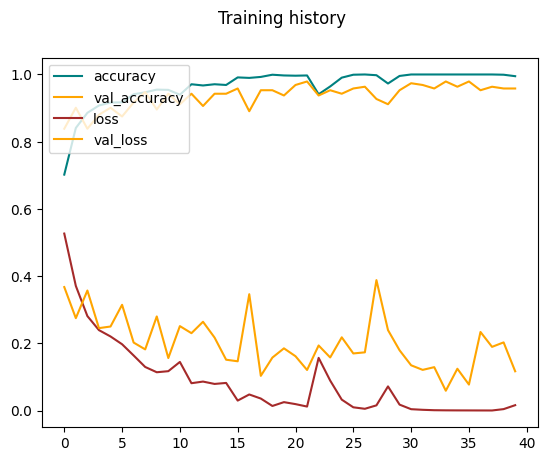

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(hist.history['loss'], color='brown', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='upper left')
fig.suptitle('Training history')
plt.show()

6. Evaluation

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()


In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 20ms/step


In [28]:
print("Precision: ", pre.result().numpy())
print("Recall: ", rec.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  1.0
Recall:  1.0
Accuracy:  1.0


7. Test

In [29]:
import cv2
image_path = "archive/flowers/outer/960x0.webp"
image_path = "dataset/daisy/134409839_71069a95d1_m.jpg"
# image_path = "dataset/rose/295257304_de893fc94d.jpg"
# image_path = "dataset/rose/27619697563_228f5c4677_n.jpg"
# image_path = "archive/flowers/outer/360_F_112824975_5fILgyzThND6nmq8sycuyF8j8pKnpAgl.jpg"
# image_path = "archive/flowers/outer/F1271-1.webp"
image_path = "dataset/sunflower/29972905_4cc537ff4b_n.jpg"
# image_path = "dataset/sunflower/151898652_b5f1c70b98_n.jpg"
# image_path = "archive/flowers/outer/360_F_575078345_LryQMyfSCcKL4e8uUYw1LJ2Re6ffn2cF.jpg"
# image_path = "archive/flowers/outer/transparent-sunflower-651d0e8c7c3ce8.0350226316964030845089.jpg"
image = cv2.imread(image_path)

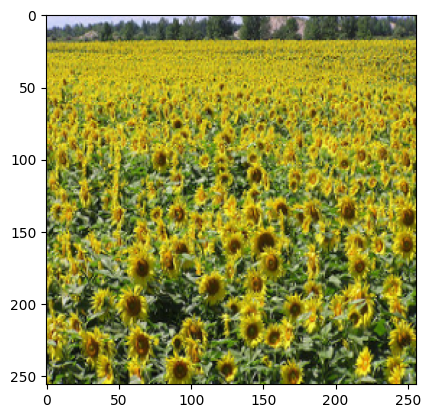

In [30]:
resized = cv2.resize(image, (256, 256))
# change color space
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

8. Prediction

In [31]:
yhat = model.predict(np.expand_dims(resized/255.0, 0))
print(yhat)
print(np.argmax(yhat[0]))

1/1 [==============================] - 0s 216ms/step
[[0.02104207 0.9789579 ]]
1
